## <u><b>[Udemy] 시계열 데이터 분석 with 파이썬 - 83

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Data/Alcohol_Sales.csv', index_col='DATE', parse_dates=True)
df.index.freq = 'MS'

In [3]:
df.head()

,S4248SM144SCEN
DATE,
1992-01-01,4302
1992-02-01,4323
1992-03-01,4199
1992-04-01,4397
1992-05-01,4159


In [4]:
df.columns = ['Sales']

<AxesSubplot: xlabel='DATE'>

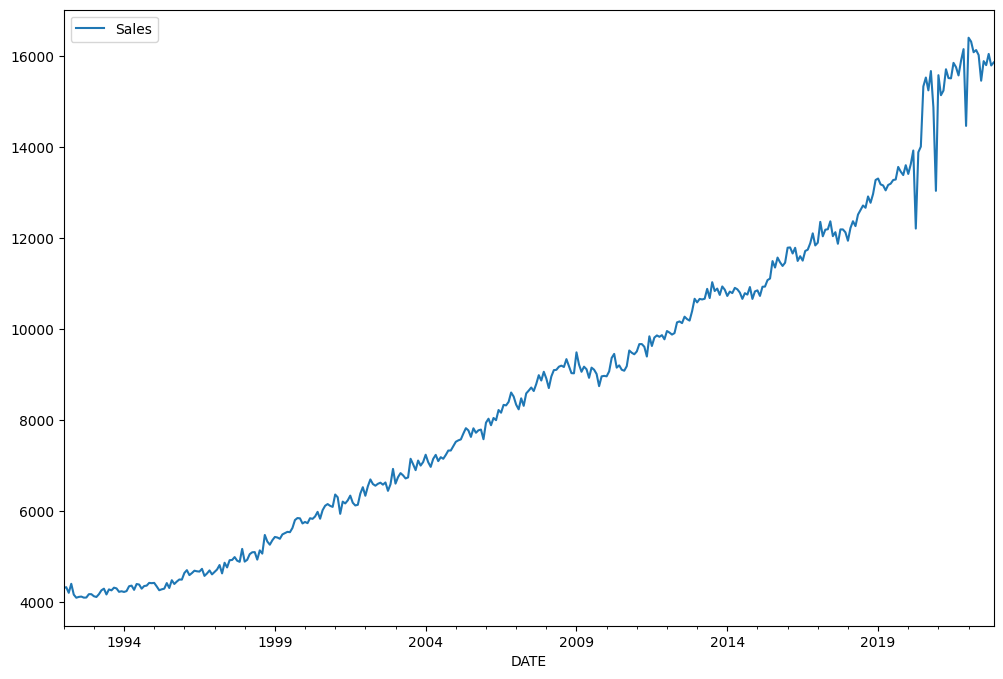

In [5]:
df.plot(figsize=(12,8))

In [6]:
!python -m pip install statsmodels 

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [8]:
results = seasonal_decompose(df['Sales'])

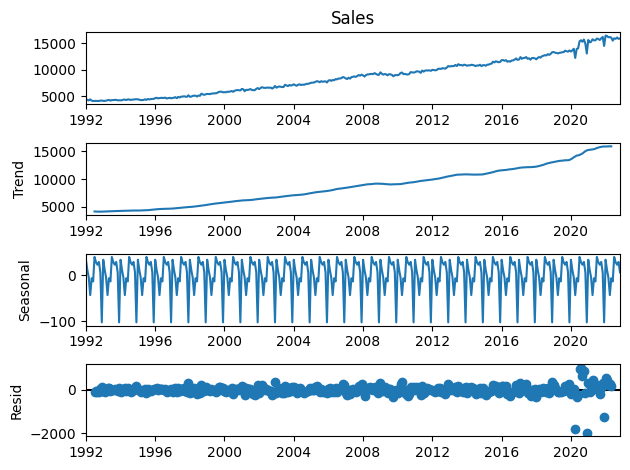

In [9]:
results.plot();

<AxesSubplot: xlabel='DATE'>

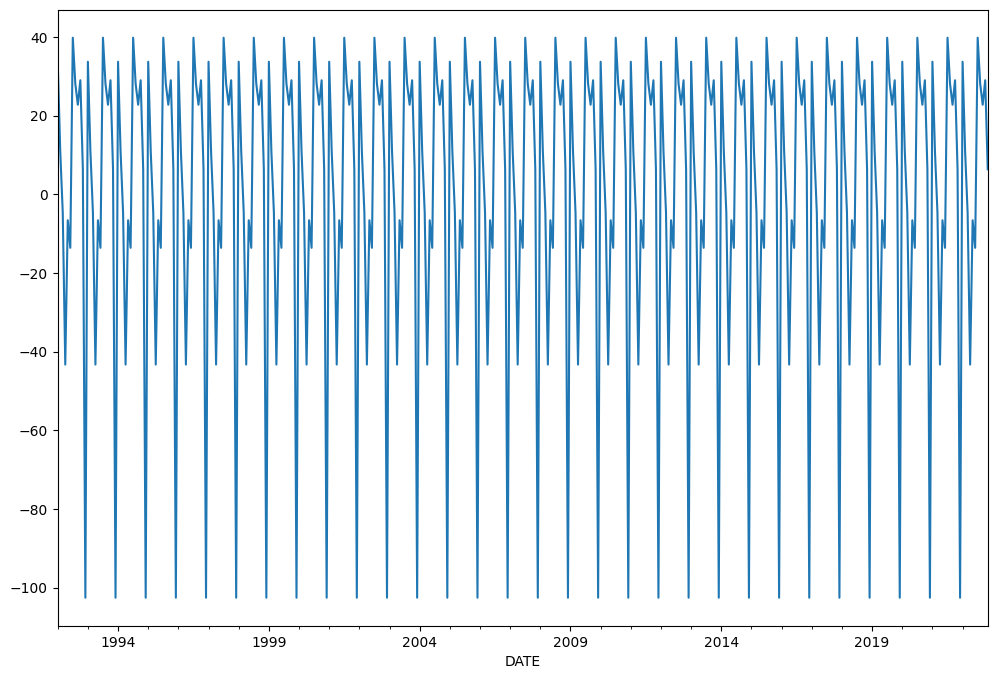

In [10]:
results.seasonal.plot(figsize=(12,8))

In [11]:
results.seasonal

DATE
1992-01-01    33.686718
1992-02-01    10.996440
1992-03-01    -4.603560
1992-04-01   -43.289671
1992-05-01    -6.609116
                ...    
2022-07-01    39.795051
2022-08-01    28.092273
2022-09-01    22.756162
2022-10-01    28.981162
2022-11-01     6.370051
Freq: MS, Name: seasonal, Length: 371, dtype: float64

In [12]:
len(df)

371

In [13]:
# 미래 1년 예측
371-12

359

In [14]:
train = df.iloc[:359]
test = df.iloc[359:]

In [15]:
test

,Sales
DATE,
2021-12-01,14465
2022-01-01,16404
2022-02-01,16319
2022-03-01,16085
2022-04-01,16133
2022-05-01,16023
2022-06-01,15459
2022-07-01,15889
2022-08-01,15801


In [16]:
len(test) # 마지막 년도만 포함됨

12

In [17]:
# 정규화 -> 범위가 뒤죽박죽인 데이터를 0~1사이로 정규화

ser = np.array([23, 56, 2, 13, 14]) # original
# 정규화 적용
ser.max() # fit
ser / ser.max() # transform

array([0.41071429, 1.        , 0.03571429, 0.23214286, 0.25      ])

In [18]:
!pip install -U scikit-learn

In [19]:
from sklearn.preprocessing import MinMaxScaler # 정규화를 위한 라이브러리

scaler = MinMaxScaler()
scaler.fit(train) # finds the max value in train data

MinMaxScaler()

In [20]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

#### Generator 알기

In [21]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [22]:
scaled_train[:5]

array([[0.01749295],
       [0.01923396],
       [0.00895374],
       [0.02536893],
       [0.00563754]])

In [23]:
n_input = 3
n_features = 1

generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [24]:
len(scaled_train)

359

In [25]:
len(generator) # sclaed_train - n_input

356

In [26]:
# 위에 설정한 것과 동일한 것을 확인할 수 있음.
# 이를 통해 generator 객체는 원하는 입력 개수대로 데이터를 가져오고 바로 다음 시점을 반환할 수 있음을 알 수 있음.
# 이는 순환 신경망과 연관 있음! 다음 포인트를 정할 수 있기 때문 ~
# 위에 설정한 batch_size는 아래의 데이터를 몇 개의 batch로 할 건지에 대한 것임.
# 계절성이 뚜렷한 데이터셋이라면 순한 신경망이 계절성을 찾을 수 있도록 적어도 input을 12개의 데이터 포인트를 입력할 것

X, y = generator[0]

print(X,"\n") 
print(X.shape,"\n")
print(y)

[[[0.01749295]
  [0.01923396]
  [0.00895374]]] 

(1, 3, 1) 

[[0.02536893]]


In [27]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

n_input = 12
n_features = 1

train_generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

model = Sequential()

model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(64))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

Metal device set to: Apple M1


2023-01-31 11:21:30.344730: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-31 11:21:30.345017: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 150)               91200     
                                                                 
 dense (Dense)               (None, 64)                9664      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 100,929
Trainable params: 100,929
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.fit_generator(train_generator, epochs=25)

Epoch 1/25


/var/folders/40/c3b3k6gx3fgb1p9w_gczw1lc0000gn/T/ipykernel_51548/4223744015.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, epochs=25)
2023-01-31 11:21:30.736082: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-31 11:21:31.199232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


347/347 [==============================] - 92s 263ms/step - loss: 0.0044
Epoch 2/25
347/347 [==============================] - 91s 263ms/step - loss: 0.0013
Epoch 3/25
347/347 [==============================] - 90s 260ms/step - loss: 9.2164e-04
Epoch 4/25
347/347 [==============================] - 90s 260ms/step - loss: 0.0012
Epoch 5/25
347/347 [==============================] - 90s 260ms/step - loss: 9.8193e-04
Epoch 6/25
347/347 [==============================] - 90s 259ms/step - loss: 0.0011
Epoch 7/25
347/347 [==============================] - 92s 265ms/step - loss: 0.0011
Epoch 8/25
347/347 [==============================] - 95s 274ms/step - loss: 0.0016
Epoch 9/25
347/347 [==============================] - 91s 264ms/step - loss: 9.9736e-04
Epoch 10/25
347/347 [==============================] - 91s 262ms/step - loss: 8.5817e-04
Epoch 11/25
347/347 [==============================] - 90s 261ms/step - loss: 8.9244e-04
Epoch 12/25
347/347 [==============================] - 90s 258ms/

In [30]:
model.history.history.keys()

dict_keys(['loss'])

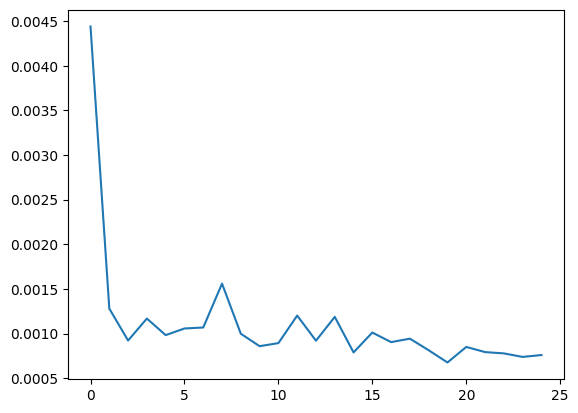

In [31]:
myloss = model.history.history['loss']
plt.plot(range(len(myloss)), myloss)

In [32]:
# 12 history steps ---> step 13
# last 12 point train ---> pt 1 of test data

In [33]:
first_eval_batch = scaled_train[-12:]
first_eval_batch

array([[0.74166805],
       [0.95249544],
       [0.91601724],
       [0.92447355],
       [0.96335599],
       [0.94727243],
       [0.946775  ],
       [0.97496269],
       [0.96716962],
       [0.95208092],
       [0.97894213],
       [1.        ]])

In [34]:
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))

In [35]:
model.predict(first_eval_batch)

1/1 [==============================] - 0s 376ms/step


2023-01-31 11:59:32.243754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([[0.96426]], dtype=float32)

In [36]:
scaled_test

array([[0.86005638],
       [1.02080915],
       [1.01376223],
       [0.99436246],
       [0.9983419 ],
       [0.98922235],
       [0.94246394],
       [0.97811308],
       [0.97081744],
       [0.99129498],
       [0.97023711],
       [0.97570884]])

#### FORECAST USING RNN MODEL

In [37]:
# holding my predictions
test_predictions = []

# last n_input points from the training set
first_eval_batch = scaled_train[-n_input:]
# reshape this to the format RNN wants (same format as TimeseriesGenerator)
current_batch = first_eval_batch.reshape((1, n_input, n_features))

# how far into the future will I forecast?
# len(test) --> 24
for i in range(len(test)):
    
    # One timestep ahead of historical 12 points
    current_pred = model.predict(current_batch)[0]
    
    # store that prediction
    test_predictions.append(current_pred)
    
    # UPDATE current batch to include prediction
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

1/1 [==============================] - 0s 61ms/step


In [38]:
test_predictions

[array([0.96426], dtype=float32),
 array([0.95660347], dtype=float32),
 array([0.9492991], dtype=float32),
 array([0.9420924], dtype=float32),
 array([0.93502593], dtype=float32),
 array([0.92808944], dtype=float32),
 array([0.9214382], dtype=float32),
 array([0.91506654], dtype=float32),
 array([0.9088361], dtype=float32),
 array([0.9027773], dtype=float32),
 array([0.8969289], dtype=float32),
 array([0.89123386], dtype=float32)]

In [39]:
true_predictions = scaler.inverse_transform(test_predictions)

In [40]:
true_predictions

array([[15721.9039042 ],
       [15629.55102456],
       [15541.44570875],
       [15454.51875401],
       [15369.28277254],
       [15285.6148237 ],
       [15205.38777542],
       [15128.53260839],
       [15053.38135576],
       [14980.29996371],
       [14909.75646949],
       [14841.06283677]])

In [41]:
test['Predictions'] = true_predictions

/var/folders/40/c3b3k6gx3fgb1p9w_gczw1lc0000gn/T/ipykernel_51548/4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [42]:
test

,Sales,Predictions
DATE,,
2021-12-01,14465,15721.903904
2022-01-01,16404,15629.551025
2022-02-01,16319,15541.445709
2022-03-01,16085,15454.518754
2022-04-01,16133,15369.282773
2022-05-01,16023,15285.614824
2022-06-01,15459,15205.387775
2022-07-01,15889,15128.532608
2022-08-01,15801,15053.381356


<AxesSubplot: xlabel='DATE'>

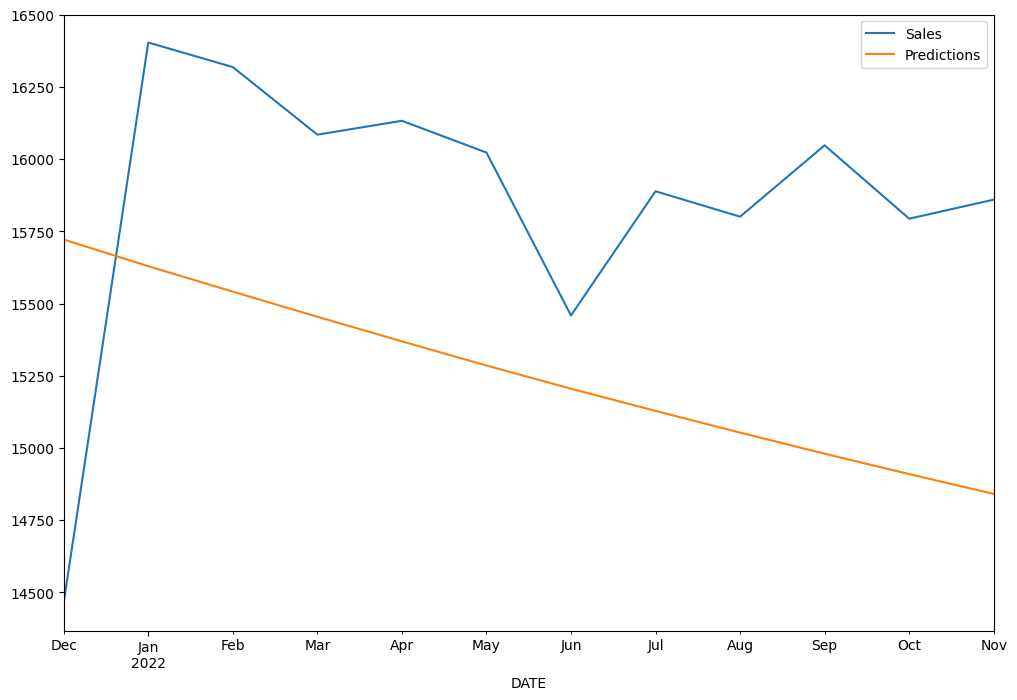

In [43]:
test.plot(figsize=(12,8))

In [44]:
model.save('mycoolmodel.h5')

In [45]:
pwd

'/Users/inslab/SOYEON/Time-Series'

In [46]:
from keras.models import load_model

new_model = load_model('mycoolmodel.h5')

new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 150)               91200     
                                                                 
 dense (Dense)               (None, 64)                9664      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 100,929
Trainable params: 100,929
Non-trainable params: 0
_________________________________________________________________
